Summary:

Load the environmental data and clinical data

Merge the ExC data 

Save ExC files 

Clean and preprocess the data (check for missing values, data types, encode categories).

Define features (X) and target (y).

Split into train and test sets.

Train MultiOutputRegressor with Random Forest model.

Predict on test set

Evaluate performance (R², RMSE)

Inspect feature importance.

In [1]:
import pandas as pd

# Load the environmental data
env_data = pd.read_csv(
    "C:/Users/emman/Downloads/PM2.5_Pollution_Data-Public/Scripts/Environmental_Data/Imputed_Clean_Environmental_Data/Finial_Prophet_Imputed_Cleaned_Environmental_Data.csv"
)

# Load the clinical data
clinical_data = pd.read_csv(
    "C:/Users/emman/Downloads/PM2.5_Pollution_Data-Public/Scripts/Clinical_Data/Phenotype_Disease_Conditions/Merged_Clinical_Filtered_Data/merged_clinical_data_V1.csv"
)

# Extract numeric Year from clinical Time period
clinical_data['Year'] = clinical_data['Time period'].str.extract(r'(\d{4})').astype(int)

# Optional: rename columns to avoid duplicates
# For example, if both datasets have 'Area Name'
# env_data.rename(columns={'Local Authority Name': 'Env_Local_Authority_Name'}, inplace=True)
# clinical_data.rename(columns={'Area Name': 'Clinical_Area_Name'}, inplace=True)

# Check columns first
print(env_data.columns.tolist())
print(clinical_data.columns.tolist())

# Rename to avoid confusion
env_data.rename(columns={'Local Authority Name': 'Env_Local_Authority_Name'}, inplace=True)
clinical_data.rename(columns={'Area Name': 'Clinical_Area_Name'}, inplace=True)


# Merge environmental and clinical data on Area Code and Year
merged_data2 = pd.merge(
    env_data,
    clinical_data,
    left_on=['Area Code', 'Year'],
    right_on=['Area Code', 'Year'],
    how='inner'
)

# Columns you want to keep
columns_of_interest = [
    'Env_Local_Authority_Name',        # renamed environmental column
    'Clinical_Area_Name',              # renamed clinical column
    'Year',
    'Sex', 'Age',
    'PM2.5_Total',                     # from environmental data
    'PM2.5_Anthropogenic',
    'PM2.5_Non_Anthropogenic',
    'Condition', 'Value', 'Count', 'Denominator',     # from clinical data
    'Lower CI 95.0 limit', 'Upper CI 95.0 limit',
    'Lower CI 99.8 limit', 'Upper CI 99.8 limit',
    'Compared to England value or percentiles',
    'Time period'                      
]


# Select only the columns you want
merged_data2 = merged_data2[columns_of_interest]
# Display first few rows
print(merged_data2.head())


['Numeric Area Code', 'Area Code', 'Local Authority Name', 'Year', 'PM2.5_Anthropogenic', 'PM2.5_Non_Anthropogenic', 'PM2.5_Total', 'PM2.5_Anthropogenic_ImputationMethod', 'PM2.5_Non_Anthropogenic_ImputationMethod', 'PM2.5_Total_ImputationMethod']
['Indicator ID', 'Indicator Name', 'Parent Code', 'Parent Name', 'Area Code', 'Area Name', 'Area Type', 'Sex', 'Age', 'Category Type', 'Category', 'Time period', 'Value', 'Lower CI 95.0 limit', 'Upper CI 95.0 limit', 'Lower CI 99.8 limit', 'Upper CI 99.8 limit', 'Count', 'Denominator', 'Value note', 'Recent Trend', 'Compared to England value or percentiles', 'Compared to percentiles', 'Time period Sortable', 'New data', 'Compared to goal', 'Time period range', 'Condition', 'Year']
  Env_Local_Authority_Name Clinical_Area_Name  Year      Sex       Age  \
0                 Barnsley           Barnsley  2012  Persons   18+ yrs   
1                 Barnsley           Barnsley  2014  Persons   18+ yrs   
2                 Barnsley           Barnsle

In [2]:
print(merged_data2.columns.tolist())


['Env_Local_Authority_Name', 'Clinical_Area_Name', 'Year', 'Sex', 'Age', 'PM2.5_Total', 'PM2.5_Anthropogenic', 'PM2.5_Non_Anthropogenic', 'Condition', 'Value', 'Count', 'Denominator', 'Lower CI 95.0 limit', 'Upper CI 95.0 limit', 'Lower CI 99.8 limit', 'Upper CI 99.8 limit', 'Compared to England value or percentiles', 'Time period']


In [5]:
# Save the merged dataset to a CSV
merged_data2.to_csv("merged_environmental_clinical_data-v2.csv", index=False)

print("Merged file saved successfully!")


Merged file saved successfully!


In [6]:
import pandas as pd
#Define the path to the merged CSV file
merge_file_path = "merged_environmental_clinical_data-v2.csv" #call the merge file

#Load the CSV file into a DataFrame using pd.read_csv
merged_data2 = pd.read_csv(merge_file_path)


In [3]:
#Check for missing values and gaps in each column of the data
print(merged_data2.isnull().sum())


Env_Local_Authority_Name                      0
Clinical_Area_Name                            0
Year                                          0
Sex                                           0
Age                                           0
PM2.5_Total                                   0
PM2.5_Anthropogenic                           0
PM2.5_Non_Anthropogenic                       0
Condition                                     0
Value                                        62
Count                                        62
Denominator                                  62
Lower CI 95.0 limit                          50
Upper CI 95.0 limit                          50
Lower CI 99.8 limit                         173
Upper CI 99.8 limit                         173
Compared to England value or percentiles      0
Time period                                   0
dtype: int64


In [4]:
#Ensure data types are correct
print(merged_data2.dtypes)

Env_Local_Authority_Name                     object
Clinical_Area_Name                           object
Year                                          int64
Sex                                          object
Age                                          object
PM2.5_Total                                 float64
PM2.5_Anthropogenic                         float64
PM2.5_Non_Anthropogenic                     float64
Condition                                    object
Value                                       float64
Count                                       float64
Denominator                                 float64
Lower CI 95.0 limit                         float64
Upper CI 95.0 limit                         float64
Lower CI 99.8 limit                         float64
Upper CI 99.8 limit                         float64
Compared to England value or percentiles     object
Time period                                  object
dtype: object


In [5]:
#Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

1.7.1


In [6]:
#Define features and target

#Features: All columns except health outcomes, metadata, or irrelevant identifiers
feature = merged_data2.drop(columns=[
    'Value', 'Count', 'Denominator', 
    'Lower CI 95.0 limit', 'Upper CI 95.0 limit', 
    'Lower CI 99.8 limit', 'Upper CI 99.8 limit',
    'Compared to England value or percentiles', 'Env_Local_Authority_Name',
    'Clinical_Area_Name', 'Time period'
])

#Target: Health outcome measures we want to predict
target = merged_data2[[
    'Value', 'Count', 'Denominator', 
    'Lower CI 95.0 limit', 'Upper CI 95.0 limit', 
    'Lower CI 99.8 limit', 'Upper CI 99.8 limit'
]]# These reflect health outcomes or statistical meassure that i can model to prdict
#What factors influence PM2.5 levels and related health measures?” or predicting PM2.5/health outcomes from other variables. 
#PM2.5 and demographics are biologically meaningful predictors.
#Health outcomes are what we aim to model or predict.

In [7]:
#Split data into training and testing sets
# 80% for training, 20% for testing
feature_train, feature_test, target_train, target_test = train_test_split(
    feature, target, test_size=0.2, random_state=42
)

In [8]:
print(feature_train.columns)


Index(['Year', 'Sex', 'Age', 'PM2.5_Total', 'PM2.5_Anthropogenic',
       'PM2.5_Non_Anthropogenic', 'Condition'],
      dtype='object')


In [9]:
print(feature_test.columns)


Index(['Year', 'Sex', 'Age', 'PM2.5_Total', 'PM2.5_Anthropogenic',
       'PM2.5_Non_Anthropogenic', 'Condition'],
      dtype='object')


In [10]:
print(target_train.columns)


Index(['Value', 'Count', 'Denominator', 'Lower CI 95.0 limit',
       'Upper CI 95.0 limit', 'Lower CI 99.8 limit', 'Upper CI 99.8 limit'],
      dtype='object')


In [11]:
print(target_test.columns)


Index(['Value', 'Count', 'Denominator', 'Lower CI 95.0 limit',
       'Upper CI 95.0 limit', 'Lower CI 99.8 limit', 'Upper CI 99.8 limit'],
      dtype='object')


**Handle categorical encoding and missing values**

In [12]:
#Handle categorical encoding and missing values

#locate numeric and categorical columns like object or strings
categorical_cols = feature_train.select_dtypes(include='object').columns
#Identify numeric columns (everything else)
numeric_cols = feature_train.select_dtypes(exclude='object').columns
#Print categorical columns to inspect them
print(categorical_cols)
print(numeric_cols)

Index(['Sex', 'Age', 'Condition'], dtype='object')
Index(['Year', 'PM2.5_Total', 'PM2.5_Anthropogenic',
       'PM2.5_Non_Anthropogenic'],
      dtype='object')


In [13]:
#One-hot encode categorical features for example Condition column
#OneHotEncoder is from sklearn.preprocessing
encoder = OneHotEncoder(
    handle_unknown='ignore', #handles errors if test data has unseen categories during training.
    sparse_output=False)#make sure output is in regular array, which is easier to inspect and concatenate.

#Fit the encoder by reading the training categorical columns and transform each categorical column into multiple binary columns 0 or 1 
feature_train_encoded = encoder.fit_transform(feature_train[categorical_cols])

#Applies the same transformation to the test set.
feature_test_encoded = encoder.transform(feature_test[categorical_cols])
#Ensures consistency between training and testing features.


In [14]:
print (feature_train_encoded)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]]


In [15]:
print (feature_test_encoded)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [16]:
#Combine numeric columns with encoded categorical columns
#Extract raw numeric values from the training set
feature_train_final = np.hstack([feature_train[numeric_cols].values, feature_train_encoded])#np.hstack() stacks arrays columns side-by-side and using the numpy model [.values] ensures columns in array format and pulls out the numeric columns like PM2.5 levels, Year, Sex, Age ready to create a full feature matrix for training, combining both types of data for concatenation 
feature_test_final = np.hstack([feature_test[numeric_cols].values, feature_test_encoded])#Repeat for the test set

In [17]:
print (feature_train_final)

[[2.01900e+03 9.29900e+00 8.84970e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.02100e+03 7.22700e+00 6.72320e+00 ... 0.00000e+00 1.00000e+00
  0.00000e+00]
 [2.02300e+03 6.90020e+00 6.34220e+00 ... 1.00000e+00 0.00000e+00
  0.00000e+00]
 ...
 [2.01800e+03 7.96100e+00 7.63520e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.01800e+03 1.25419e+01 1.20586e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.02000e+03 5.46090e+00 4.99330e+00 ... 1.00000e+00 0.00000e+00
  0.00000e+00]]


In [18]:
print (feature_test_final)

[[2.01600e+03 9.72900e+00 9.14200e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.02200e+03 8.92950e+00 8.39730e+00 ... 0.00000e+00 1.00000e+00
  0.00000e+00]
 [2.01600e+03 1.17021e+01 1.11361e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 ...
 [2.01900e+03 7.82290e+00 7.25890e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.01200e+03 1.44593e+01 1.22853e+01 ... 0.00000e+00 1.00000e+00
  0.00000e+00]
 [2.01600e+03 1.11604e+01 1.06099e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]


In [19]:
# Impute missing values in targets using mean strategy

imputer = SimpleImputer(strategy='mean')#using SimpleImputer from sklearn.impute replaces missing values with NaNs with the mean of each column.
target_train_imputed = imputer.fit_transform(target_train)#Fit the imputer on the training target and transform it
target_test_imputed = imputer.transform(target_test)#Apply the same transformation to the test target using same mean learned from training data
#Ensures consistency between training and testing sets to avoids data leakage from the test set.

In [20]:
print (target_train_imputed)

[[9.54608520e+02 1.94686000e+03 2.42077000e+05 ... 9.98136996e+02
  8.88901411e+02 1.02362995e+03]
 [5.94770342e+00 2.24640000e+04 3.77692000e+05 ... 6.02336523e+00
  5.82986753e+00 6.06762139e+00]
 [7.45538592e+00 1.74670000e+04 2.34287000e+05 ... 7.56218207e+00
  7.28947995e+00 7.62452543e+00]
 ...
 [1.63815692e+03 2.43141000e+03 1.60955000e+05 ... 1.70649448e+03
  1.53452557e+03 1.74645282e+03]
 [1.69671074e+03 1.19308000e+03 1.33315000e+05 ... 1.80151683e+03
  1.54040890e+03 1.86315754e+03]
 [7.46120782e+00 1.46850000e+04 1.96818000e+05 ... 7.57766511e+00
  7.28023086e+00 7.64603331e+00]]


In [21]:
print (target_test_imputed)

[[1.06995619e+03 8.68460000e+02 9.05660000e+04 ... 1.14395736e+03
  9.60650704e+02 1.18762551e+03]
 [3.62423700e+00 5.51000000e+03 1.52032000e+05 ... 3.71885994e+00
  3.47898322e+00 3.77495495e+00]
 [1.32364979e+03 7.65990000e+02 8.32360000e+04 ... 1.42404656e+03
  1.17598410e+03 1.48337748e+03]
 ...
 [2.18765852e+02 4.47790000e+02 1.61798000e+05 ... 2.40286425e+02
  1.87786522e+02 2.53098114e+02]
 [2.28258287e+00 6.62000000e+03 2.90022329e+05 ... 2.33737528e+00
  2.19837903e+00 2.36973951e+00]
 [8.89434833e+02 1.91892000e+03 2.97451000e+05 ... 9.30653732e+02
  8.27233771e+02 9.54796727e+02]]


**Fit a MultiOutput Random Forest**

In [22]:
#create a Random Forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)#RF is a ML model that builds multiple decision trees and averages their predictions but building 100 tress for robustness and Ensures reproducibility.  

#wrap the RF ML to handle multiple target regression outputs by internally training one regressor per target column.
multi_rf = MultiOutputRegressor(rf)
multi_rf.fit(feature_train_final, target_train_imputed)#this trains the multiple target regression model using the final feature matrix and imputed targets allowing each target column gets its own RF model.

,estimator,RandomForestR...ndom_state=42)
,n_jobs,None
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


**Predict on test set**

In [23]:
predictions = multi_rf.predict(feature_test_final)#Generates predictions for each target column.

#Evaluate the model using R2 and RMSE for each target
for i, col in enumerate(target.columns):#Loops through each target column name
    r2 = r2_score(target_test_imputed[:, i], predictions[:, i])#using scikit-learn model measures how well predictions match actual values. 1 = Perfect prediction, 0.0 = model model predicts the mean and Negative = worse than predicting the mean 
    mse = mean_squared_error(target_test_imputed[:, i], predictions[:, i])#using the scikit-learn model to calculate mean sequared error (RMSE) for lower RMSE = better fit then return RMSE
    rmse = np.sqrt(mse)#using the Numpy model to manually calculate the square root to get RMSE root mean sequared error                       
    print(f"Target: {col} | R2: {r2:.3f} | RMSE: {rmse:.3f}")#show the target column r2 score and RMSE


Target: Value | R2: 0.955 | RMSE: 122.436
Target: Count | R2: 0.634 | RMSE: 4516.931
Target: Denominator | R2: 0.300 | RMSE: 106082.450
Target: Lower CI 95.0 limit | R2: 0.951 | RMSE: 121.526
Target: Upper CI 95.0 limit | R2: 0.952 | RMSE: 132.932
Target: Lower CI 99.8 limit | R2: 0.949 | RMSE: 119.248
Target: Upper CI 99.8 limit | R2: 0.951 | RMSE: 135.660


**Inspect feature importance**

From the Predict on test set data, we can see that there is data leakage issues likes Lower CI 95%, Upper CI 95%, Count, and Denominator as targets.

The problem is these are mathematically derived from Value, so predicting them is basically not good for the model. it inflates R2 values and gives misleading feature importance. 

we can see from the R2 interpretation values, that the R2 value for Value column  is 0.955 which is good for the ML model because of its real patterns. 
whereas, the other columns were moderate okay, or weak and not meaningful like Denominator  and count. ALso the CLs were 0.95 which were high and redundant.                                                                               

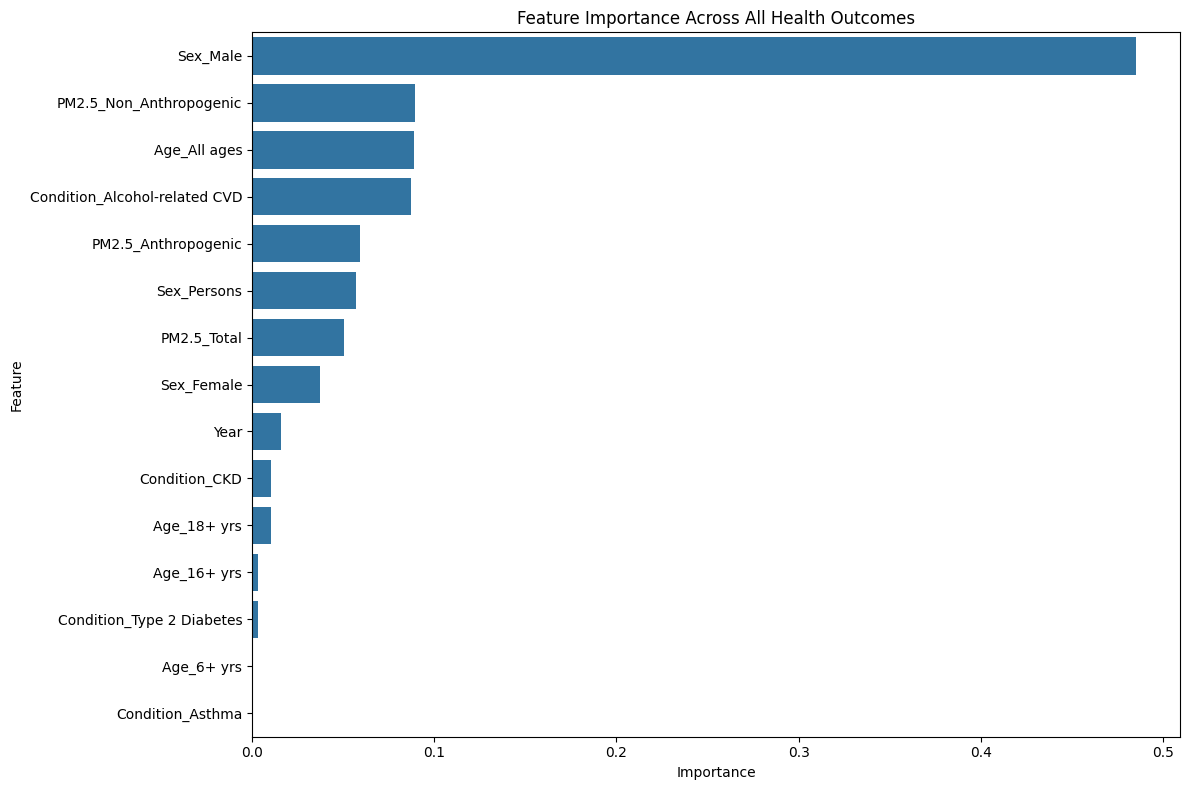

In [24]:
#Get feature importance from each individual estimator one per target column
importances = np.array([est.feature_importances_ for est in multi_rf.estimators_])#using the numpy array shape, each model target column has its own feature importance, so for each feature importance column in the multi_rf target regression outputs is a list of individual Random Forest Regressor models — one for each target. 

#Averages the feature importance across all target models showing the mean importance of each feature 
mean_importances = importances.mean(axis=0)

#Build a DataFrame to visualize the data
feature_names_final = list(numeric_cols) + list(encoder.get_feature_names_out(categorical_cols))#this combines numeric and encoded categorical feature names.
feature_importance_df = pd.DataFrame({
    'Feature': feature_names_final,
    'Importance': mean_importances
}).sort_values(by='Importance', ascending=False)#create a df with feature names and their average importance sorted from ascending to decending.

#Plot horizontal bar chart with feature importance using seaborn 
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)#plot barplot with features on the y-axis, importance on the x-axis.
plt.title("Feature Importance Across All Health Outcomes")#plot horizontal title 
plt.tight_layout()#make sure labels dont get cut off.
plt.show()#show the bar chat.

From this feature importance section, the male sex dominates due to sex difference driving raw rates or denominator very by sex 

From the result of the feature importance, it shows how much each input variable contributes to predicting the target health outcomes like value and counts and denominator. 
We can see features with high importance that strongly influence predictions and features with low importance that have little effect or may be noisy. 

From the data, we can see that the Sex_male and age_all ages are ranked high, meaning the sex and age are strong predictors of health outcomes rates.
from this same data, all PM2.5 metrics had noticeable importance aligning with the research question goal of how does air pollution exposure levels interaction, contribute to predicting health outcome risk using ML model random forest. 
Then we can also see that alcohol related CVD condition is also a very noticeable importance feature that contribute the the link of air pollution and health risk outcome.

From this results, we can see that the model is understanding that the importance features are demographics and PM2.5 levels. 

from this same results we understand that demographics and PM2.5 levels show significant importance therefore to understand how PM2.5 contribute to health outcome,
we will only compare the PM2.5 to the value only. 

Seeing as the CLs columns and others like Count, and Denominator should not be used as target or feature as they introduce leakages, redundancy and inflate R2 atificially 

In [27]:
# Create a DataFrame for each target's feature importance
target_names = target.columns.tolist()
feature_names_final = list(numeric_cols) + list(encoder.get_feature_names_out(categorical_cols))

individual_importance_df = pd.DataFrame(importances.T, index=feature_names_final, columns=target_names)

# Display top features per target
print(individual_importance_df.head(13))


                                      Value     Count  Denominator  \
Year                           7.796290e-03  0.020205     0.051600   
PM2.5_Total                    1.523460e-02  0.086455     0.184640   
PM2.5_Anthropogenic            1.537652e-02  0.127123     0.206941   
PM2.5_Non_Anthropogenic        2.956967e-02  0.153797     0.317861   
Sex_Female                     5.204828e-02  0.005040     0.000694   
Sex_Male                       6.837748e-01  0.000127     0.000740   
Sex_Persons                    3.762873e-02  0.000134     0.206037   
Age_16+ yrs                    6.812742e-05  0.001192     0.002604   
Age_18+ yrs                    7.649200e-07  0.063073     0.008476   
Age_6+ yrs                     7.431196e-08  0.001029     0.002748   
Age_All ages                   5.889877e-02  0.265479     0.002203   
Condition_Alcohol-related CVD  9.951099e-02  0.209211     0.002063   
Condition_Asthma               6.438387e-08  0.001034     0.002242   

                   

from this results, the value column shows feature importance for predicting value. 
This is where sex_female with a value of 0.052, shows that the target value feature has a relative importance of 5.2% which contributes to predicting the Value.
Where as the count and denominator columns show high importances for PM2.5 target features for example 0.317 for PM2.5 non anthropogenic. this shows the model relies heavily on pollution to predict the outcomes. 
The CLs columns also show target feature importance which are similar to value, count and denominator. However, they are derived metrics from count, denominator and values. Therfore we will remove this target feature columns as they will introduce leakage and only use the value coolumns.
Seeing as all count and denominator are mathematically linked to value which will introduce leakage and allow use to answer the main question. 

From this data, we observe some patterns which are the demographics dominate value for female sex and male sex are strongest predictors for the actual health rates.

The pollution materics matters but less than demographics for values of PM2.5 target feature have moderate importance 

Then the target leakage in CL and count and denominator, show importance jumps because those target values are obtained from the Value column and therefore, increasing the scores artifically.                                                                                                                                                                                     

Key takes and why this matter for futher analysis 

Keep Value as the main target 
Drop counts denominators and CL columns from both features and targets.
Use PM2.5 metrics + Demographics + condition as features.

This will produce cleaner, scientifically meaningful feature importance and not just inflated by target leakage.

In [22]:
#save the averaged importance
feature_importance_df.to_csv("mean_feature_importance.csv", index=False)

In [ ]:
#save the individual importance per target
individual_importance_df.to_csv("individual_feature_importance.csv")

In [28]:
# Sort by importance first
sorted_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Show top 5 most important features
top_features = sorted_df.head(5)
print(top_features)


                          Feature  Importance
5                        Sex_Male    0.485042
3         PM2.5_Non_Anthropogenic    0.089522
10                   Age_All ages    0.089064
11  Condition_Alcohol-related CVD    0.087277
2             PM2.5_Anthropogenic    0.059422


In [42]:
#filter the averaged importance
filtered_feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > 0.001]
# Sort the filtered results by importance (descending)
filtered_feature_importance_df = filtered_df.sort_values(by='Importance', ascending=False)
print(filtered_feature_importance_df)


                          Feature  Importance
5                        Sex_Male    0.485042
3         PM2.5_Non_Anthropogenic    0.089522
10                   Age_All ages    0.089064
11  Condition_Alcohol-related CVD    0.087277
2             PM2.5_Anthropogenic    0.059422
6                     Sex_Persons    0.057367
1                     PM2.5_Total    0.050610
4                      Sex_Female    0.037456
0                            Year    0.016175
13                  Condition_CKD    0.010496
8                     Age_18+ yrs    0.010222
7                     Age_16+ yrs    0.003252
14      Condition_Type 2 Diabetes    0.003088


**From here on out we will be filtering this data more to only use Value as the main target so we can see how Air pollution contribute to health outcomes.**

We will have no leakages from count, Denominator or CLs columns 

We will also see whcih PM2.5 metrics and demographics most influence the target which is the Value.

Plans:
Drop unnecessary columns like Count, Denominator and CIs.

Define features and target.

Encode categorical variables.

Train a Random Forest to predict Value.

Show feature importance.

**Drop unnecessary columns**

In [31]:
#Drop all columns related to Count, Denominator, and CI
cols_to_drop = [col for col in target.columns if 'Count' in col or 'Denominator' in col or 'Lower CI 95.0 limit'  in col or 'Upper CI 95.0 limit' in col or 'Lower CI 99.8 limit' in col or 'Upper CI 99.8 limit' in col]    
target_clean = target.drop(columns=cols_to_drop)#the target should only be Value

#Also drop these columns from features if present and ensure we dont get any errors if a column isn't in features.
features_clean = feature.drop(columns=cols_to_drop, errors='ignore')


This code is dropping the nunecessary columns so in target_clean we only have the Value columns which is clinical outcome rate per condition.

In the features_clean variable, we are removing any columns that could leak informations like the target veriables Count, Denominator and CIs.


**Select feature**

In [32]:
# Include PM2.5 metrics and demographics as features
pm_cols = [col for col in features_clean.columns if 'PM2.5_Total' in col or 'PM2.5_Non_Anthropogenic' in col or 'PM2.5_Anthropogenic' in col]
demographic_cols = ['Sex', 'Age']  #actual demographic columns in the dataset

selected_features = features_clean[pm_cols + demographic_cols]#combined pm_cols and demographic cols now contain only relevant predictors


The pm-cols will find all columns related to PM2.5.
Then the demographic_cols should be manually adjusted to match my dataset.
Then the selected_feature with the combined pm_cols and demographic cols now contain only relevant predictors 

In [33]:
from sklearn.preprocessing import OneHotEncoder
#identify columns with object datatype 
categorical_cols = [col for col in selected_features.columns if selected_features[col].dtype == 'object']
encoder = OneHotEncoder(sparse_output=False, drop='first')#drop='first' avoids dummy variable trap

encoded_cat = pd.DataFrame(
    encoder.fit_transform(selected_features[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=selected_features.index
)

# Combine numerical and encoded categorical features
numeric_cols = selected_features.select_dtypes(include='number')
X = pd.concat([numeric_cols, encoded_cat], axis=1)
y = target_clean['Value']


This code identifies non-numeric columns in the categorical_cols.

converts the columns into numeric scaled 0-1 columns.

so X which is feature now has all numerical predictors.

then the y which is target, contains only Value columns. 

**Train a Random Forest**

In [34]:
#Check for missing values in y values
y.isna().sum()


np.int64(62)

We have 62 missing values in the target feature. Random forest can not work with data with missing value rows.

So to handle this we can drop rows with missing targets values. 

This is better and safer because if we fill in thoes rows, it can make the data model bias.

the only cons to this is we lose 62 rows from the dataset.

In [35]:
# Keep only rows where target is not NaN
rows_not_missing_NaN_idx = y.notna()#returns a Boolean Series indicating which rows in y are not missing (NaN).

X_clean = X.loc[rows_not_missing_NaN_idx]#keeping only the rows where the target is present.
y_clean = y.loc[rows_not_missing_NaN_idx]#keeping only the rows where the target is present.


This ensures that your model won't be trained on rows with missing target values, which would otherwise cause errors or unreliable predictions.

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)


train_test_split keeps 80% for training, 20% for testing.

the n_estimators=500 means that 500 decision tree in the random forest will be made for stability.

Then random forest (rf) will generate a prediction based on the Value column values.

**Feature Importance**

In [45]:
# Get feature importances
importances = rf.feature_importances_

# Create DataFrame for easier viewing
filtered_feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top features
print(filtered_feature_importance_df.head(10))


                   Feature    Importance
3                 Sex_Male  6.944859e-01
7             Age_All ages  1.581822e-01
4              Sex_Persons  9.409288e-02
2  PM2.5_Non_Anthropogenic  2.758233e-02
0              PM2.5_Total  1.351866e-02
1      PM2.5_Anthropogenic  1.213591e-02
5              Age_18+ yrs  2.000649e-06
6               Age_6+ yrs  1.623634e-07


rf.feature_importances_ this gives a score for each feature and this is where higher = more influence.

Feature_importance_df sorts feature by importance 

head(10) this shows the top 10 most important predictors for Valuue

**from this result, it shows that**

Male with importance value of 0.694 shows to be most influential feature in the model and looks like the model relies heavily on this for prediction.
                                                                                                                                     All ages with importance value of 0.158 shows the be second mostly influential feature which is age across all groups contributes moderately to the model prediction.
All persons with 0.094 also somewhat relevant 

PM2.5 Non_Anthropogenic with value of 0.028 from non human sources have minor influence 

PM2.5 total with value of 0.013 which is the overall PM2.5 of Non_Anthropogenic and Anthropogenic show to have very little contribution

PM2.5 Anthropogenic with value of 0.012 show very very low levels of contribution 

Then both age 18+ and 6+ with calues of 0.000002 and 0.000000 show to have zero to no influence at all. 

**Key observation from the results**

Sex features from the model shows that gender is the most strongest predictor of health issues and depending on the persons gender could influence stronger disease outcomes when exposed to PM2.5.

The age features, the only age groups that matter with more significant influence is the all age groups. showing that the values for all age groups show more corrolations for how PM2.5 on all age groups contribute to health issues. 

The PM2.5 features show low importance. maybe due to the model not getting the full effect strongly or there is a multicollinearity where some features are redundant.

Then we see that both age18 and 16 show no sign of importance therefore, we can confirm to not using them to predict any outcomes as they dont have any importance to the model. 

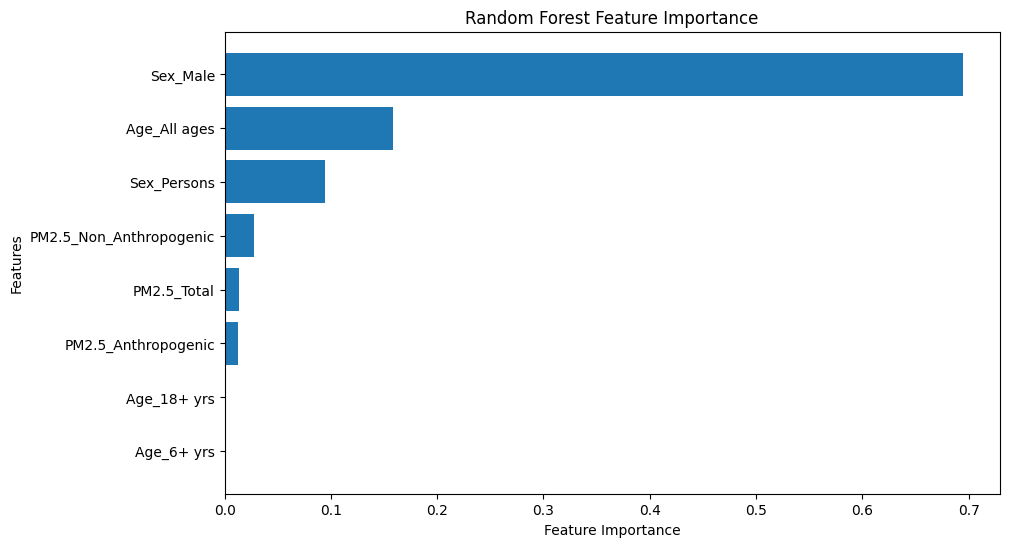

In [46]:
import matplotlib.pyplot as plt
#Plot horizontal bar chart with feature importance 
plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['Feature'], filtered_feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # Highest importance on top
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.show()


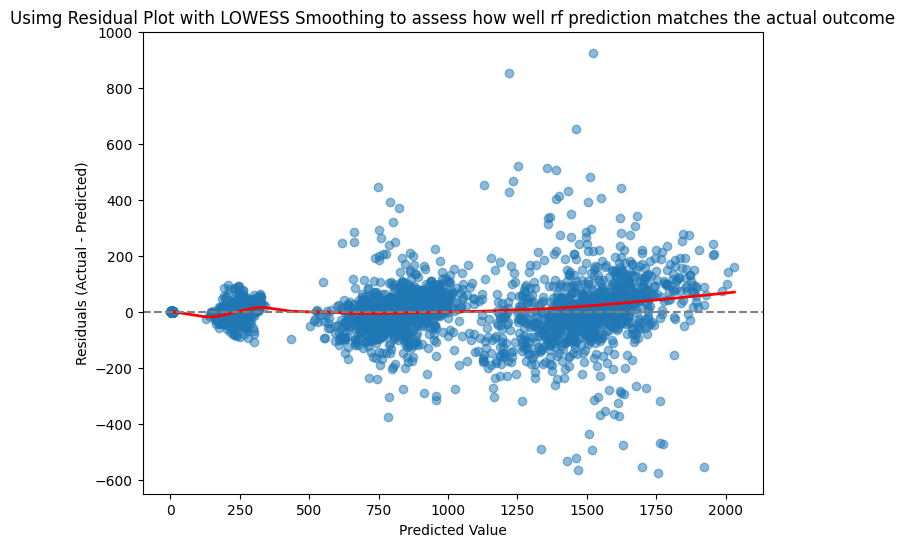

In [62]:
#Import libraries
import matplotlib.pyplot as plt#For plotting
import statsmodels.api as sm #For LOWESS smoothing
import numpy as np #For numerical operations

#residplot

#Calculate residuals
#Residuals are the difference between actual and predicted values
residuals = y_clean - y_pred_full

#Apply LOWESS smoothing
#LOWESS = Locally Weighted Scatterplot Smoothing
#This helps visualize trends in residuals without assuming a specific model
lowess = sm.nonparametric.lowess
smoothed = lowess(residuals, y_pred_full, frac=0.3)  # fraction controls the window size for smoothing level. This smooths out noise while preserving strucutre making it balanced 

#Plot the residuals and LOWESS line
plt.figure(figsize=(8,6))#Set plot size
plt.scatter(y_pred_full, residuals, alpha=0.5)#Plot raw residuals as scatter
plt.plot(smoothed[:, 0], smoothed[:, 1],#Plot LOWESS-smoothed line
         color='red', linewidth=2)# Style the line to red 
plt.axhline(0, color='gray', linestyle='--')#Add horizontal line at zero

#Label the plot
plt.xlabel("Predicted Value")#X-axis label
plt.ylabel("Residuals (Actual - Predicted)")#Y-axis label
plt.title("Residual Plot with LOWESS Smoothing to assess prediction matches the actual outcome")#Plot title
plt.show()#Display the plot


this plat from https://seaborn.pydata.org/generated/seaborn.residplot.html

this is good to view residual level for transparency and to see the levels of smoothing for more details 

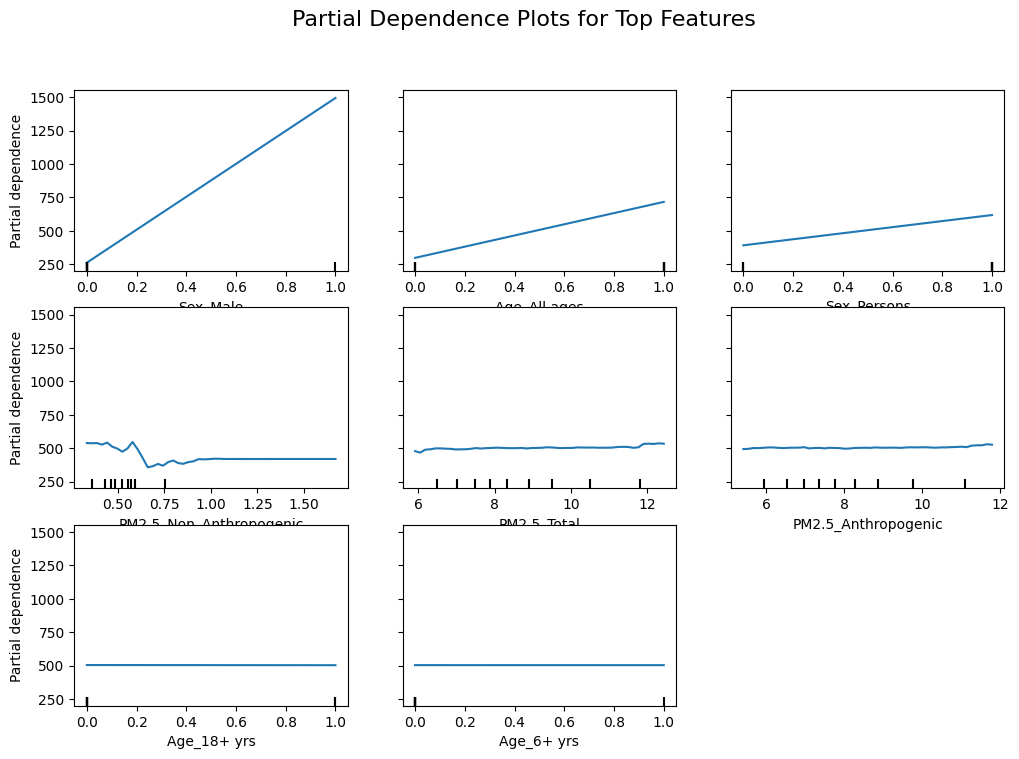

In [56]:
#Import plotting and Partial Dependence Plot (PDP) tools
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

#Select top features based on importance
#From the random forest feature importance df select top features based on importance 
top_features = filtered_feature_importance_df['Feature'].head(8).tolist()  # Top 8 most important features

#Create a figure and axis for plotting
figure, axis = plt.subplots(figsize=(12, 8))#Set plot size for clarity

#Generate Partial Dependence Plots
#PDP shows how each feature influences the predicted outcome, marginalizing over other features
PartialDependenceDisplay.from_estimator(
    rf, #trained Random Forest model
    X_clean, #The cleaned feature matrix used for prediction
    features=top_features,#List of features to plot
    kind='average',#Show average marginal effect across samples
    grid_resolution=50,#Number of points used to evaluate each feature
    ax=axis #Plot on the axis created above
)

#Add a title to the entire figure
plt.suptitle("Partial Dependence Plots for Top Features", fontsize=16)

#Display the plot
plt.show()


this plot is from https://scikit-learn.org/stable/modules/partial_dependence.html

This plot helps to interpret how each feature affects predictions and we can spot non-linear effects thresholds in model behavior.

These plots show how individual features influence the model’s predictions, while averaging out the effects of all other variables.